**Prediction of Credit Card Approval**



---


**Loading the Data and Initial Exploration**

---



In [40]:
import pandas as pd

# Load the datasets
train_data = pd.read_csv('/content/drive/MyDrive/MENTORNESS/CEDIT CARD APPROVAL PREDICTION/train_data.csv')

test_data = pd.read_csv('/content/drive/MyDrive/MENTORNESS/CEDIT CARD APPROVAL PREDICTION/test_data.csv')


# Display the first few rows of the training data
print("Training Data:")
print(train_data.head())

# Display the first few rows of the test data
print("\nTest Data:")
print(test_data.head())

# Display summary statistics for the training data
print("\nSummary Statistics:")
print(train_data.describe())

# Check for missing values in the training data
print("\nMissing Values:")
print(train_data.isnull().sum())


Training Data:
        ID Gender Has a car Has a property  Children count    Income  \
0  5037048      M         Y              Y               0  135000.0   
1  5044630      F         Y              N               1  135000.0   
2  5079079      F         N              Y               2  180000.0   
3  5112872      F         Y              Y               0  360000.0   
4  5105858      F         N              N               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working  Secondary / secondary special               Married   
1  Commercial associate               Higher education  Single / not married   
2  Commercial associate  Secondary / secondary special               Married   
3  Commercial associate               Higher education  Single / not married   
4               Working  Secondary / secondary special             Separated   

            Dwelling    Age  Employment length  Has a mobile phone  \
0



---


**Exploratory Data Analysis (EDA)**

---



Univariate Analysis<br>
*We'll start with univariate analysis to understand the distribution of individual features.*

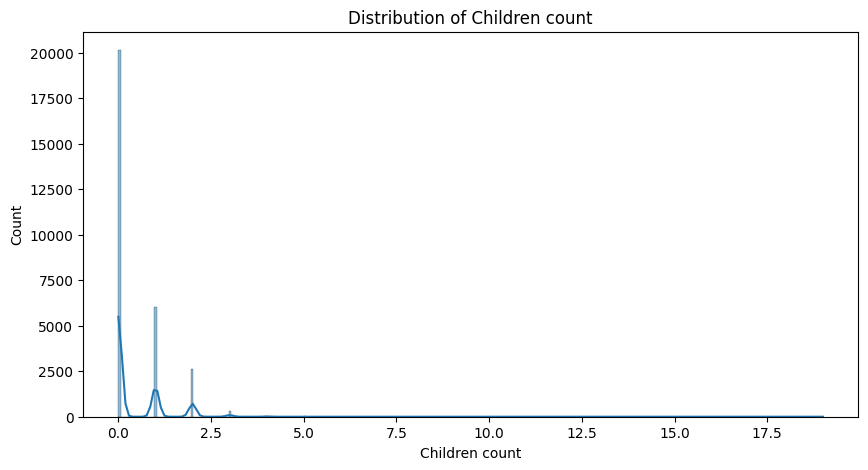

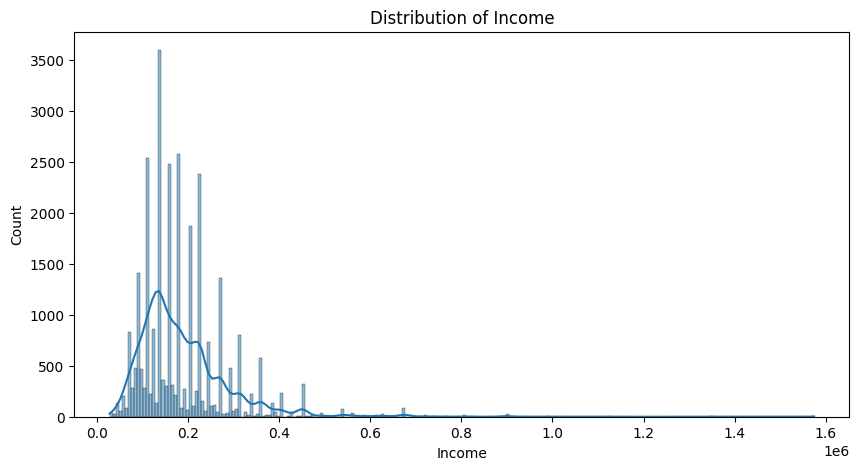

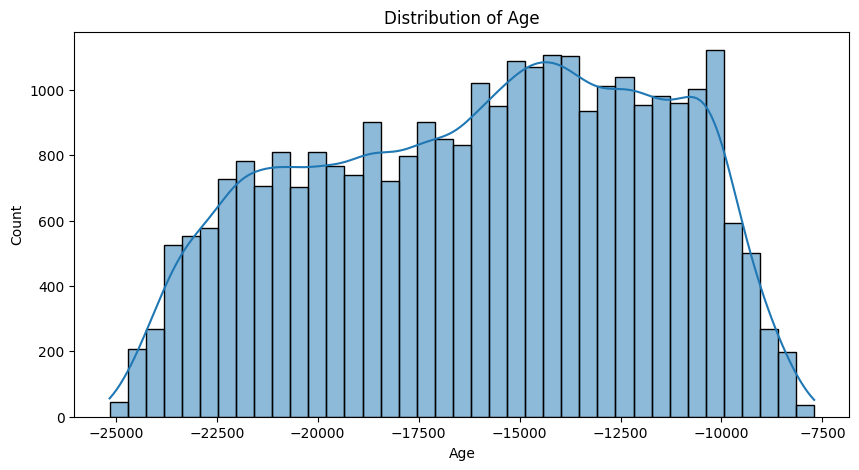

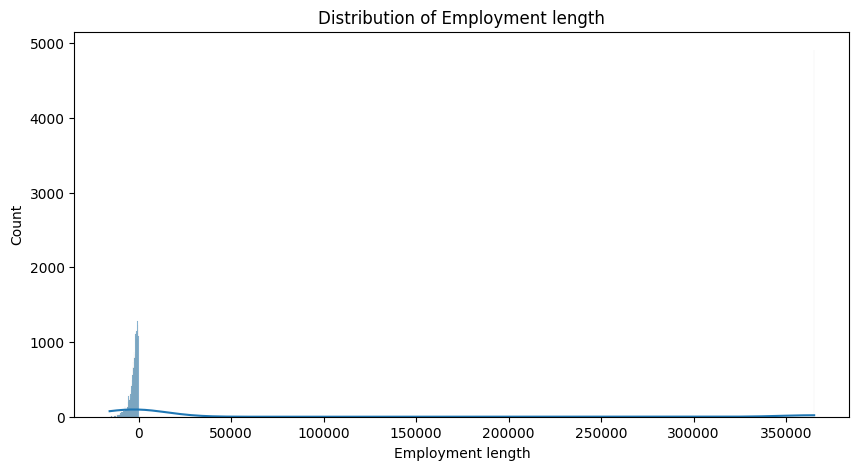

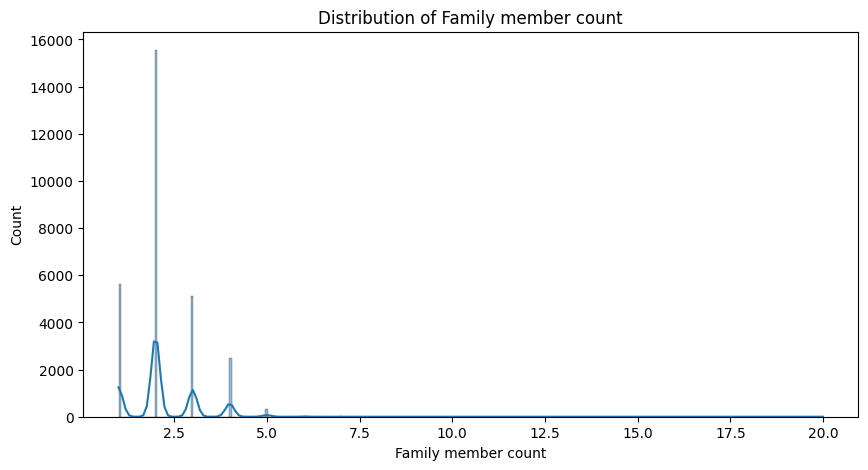

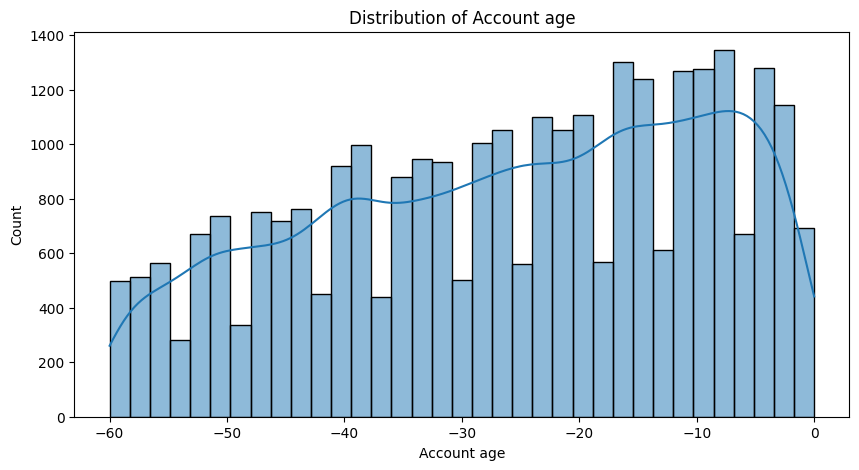

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot histograms for numerical features
def plot_histograms(data, columns):
    for column in columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(data[column].dropna(), kde=True)
        plt.title(f'Distribution of {column}')
        plt.show()

# List of numerical columns for univariate analysis
numerical_columns = ['Children count', 'Income', 'Age', 'Employment length', 'Family member count', 'Account age']

# Plot histograms for numerical columns
plot_histograms(train_data, numerical_columns)


Bivariate Analysis<br>
*let's perform bivariate analysis to see how features relate to the target variable `Is high risk.`*

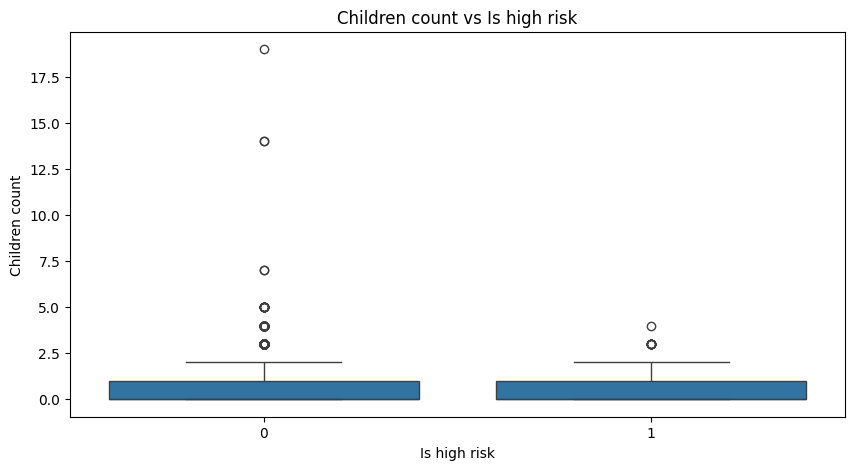

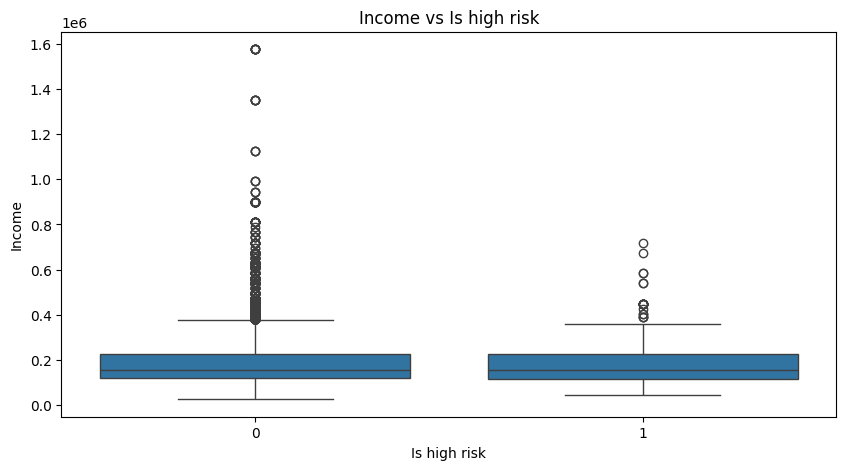

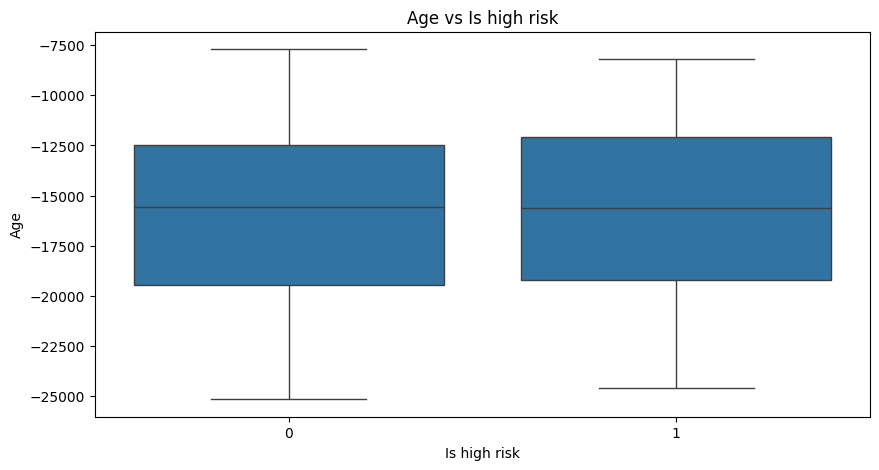

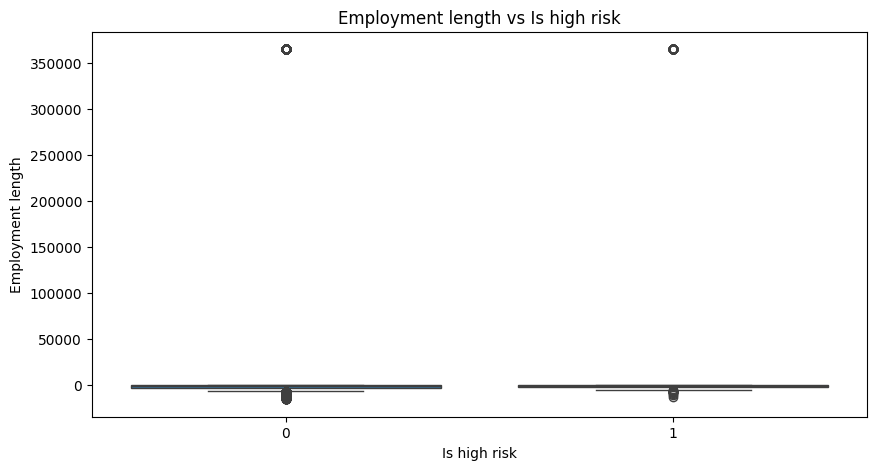

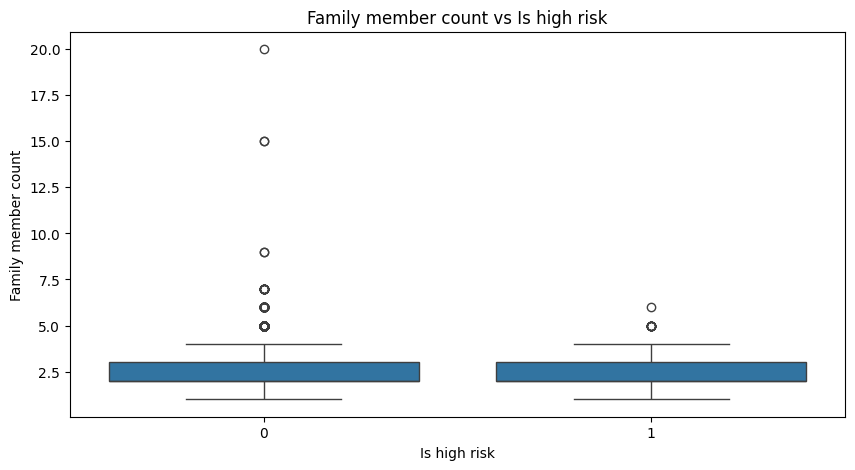

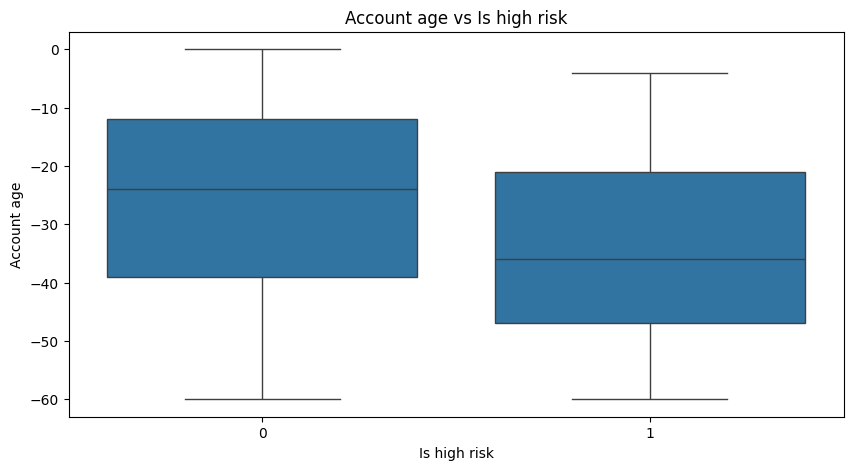

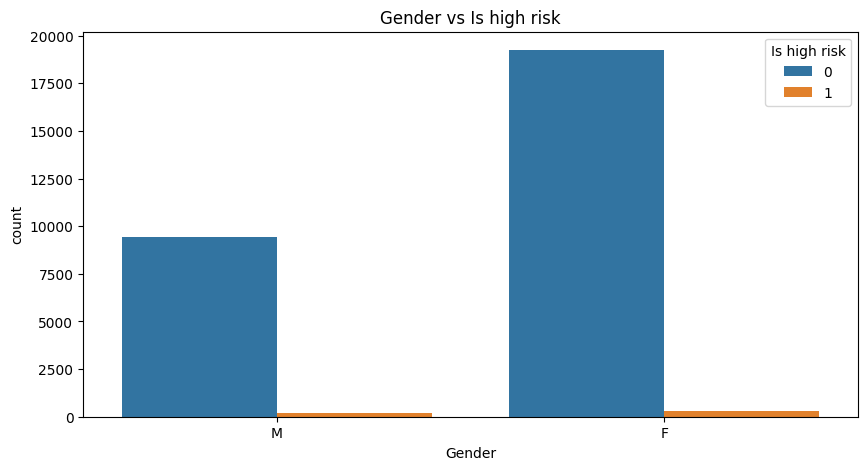

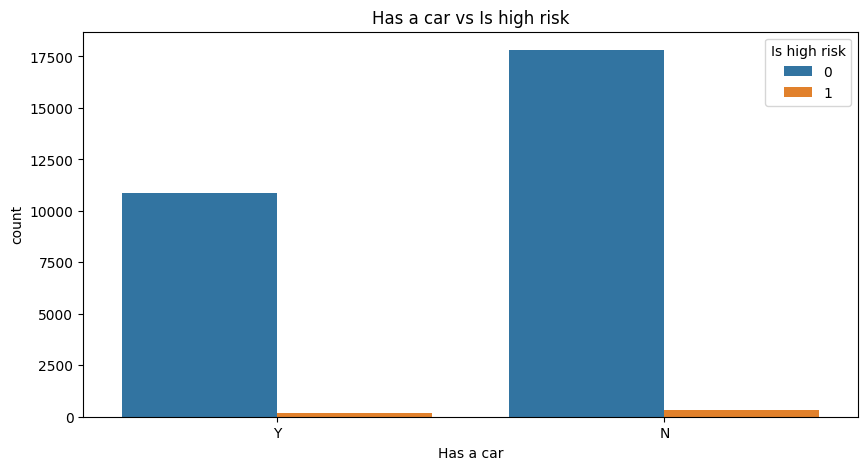

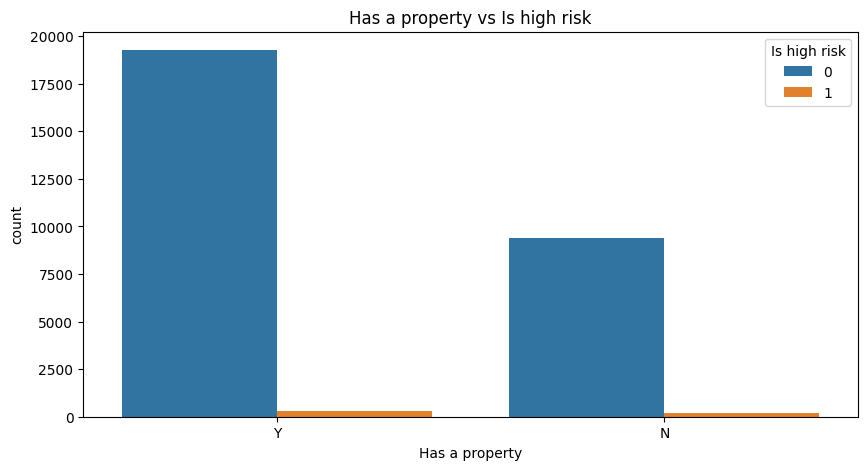

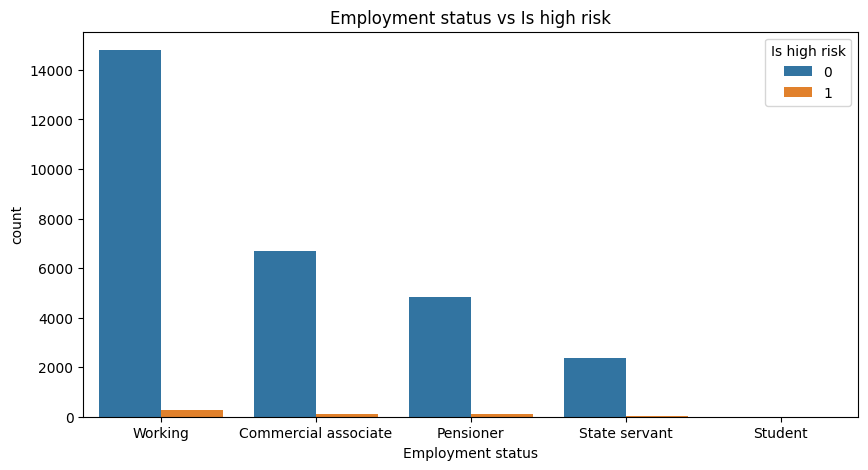

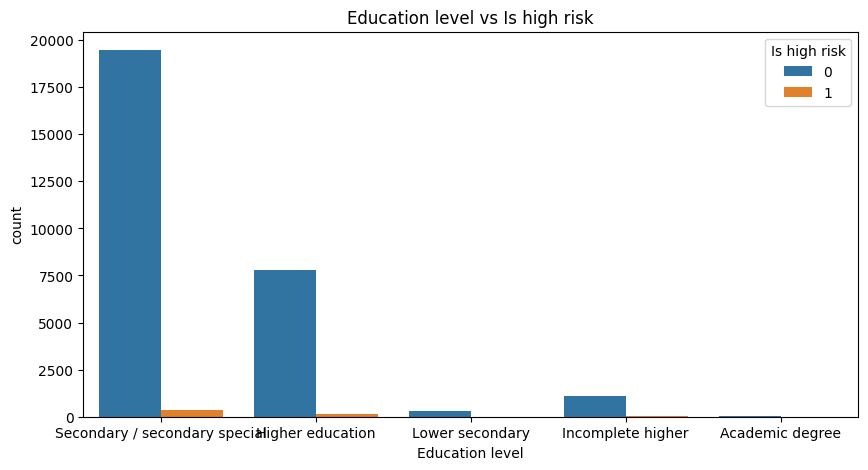

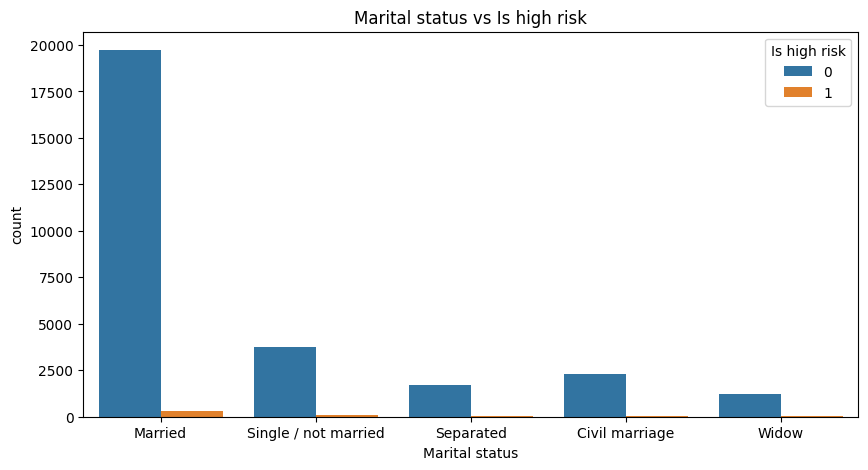

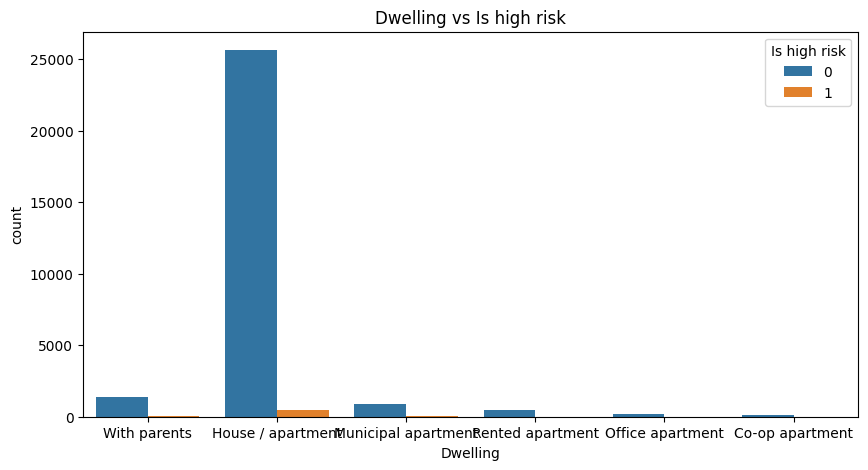

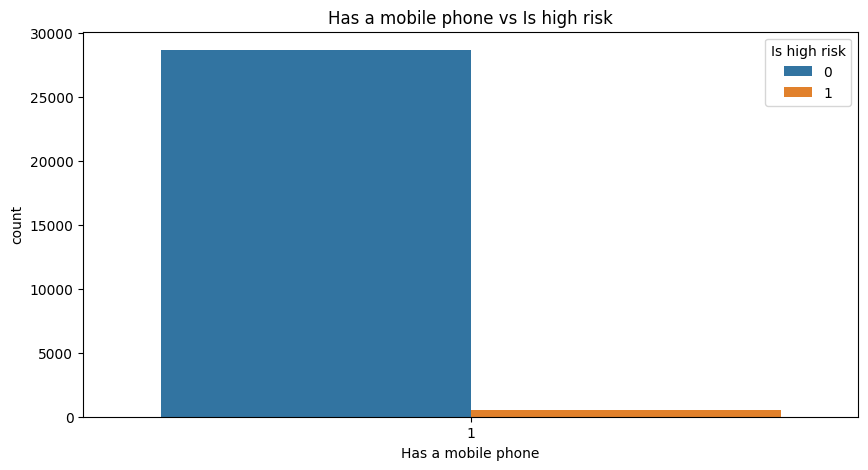

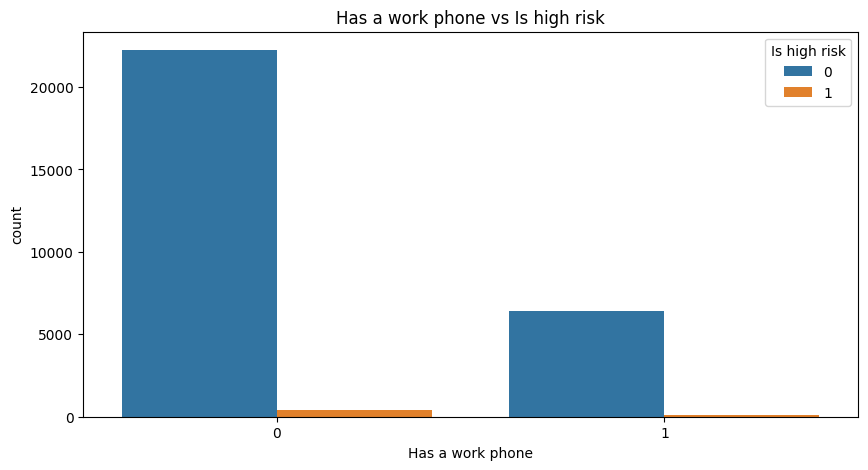

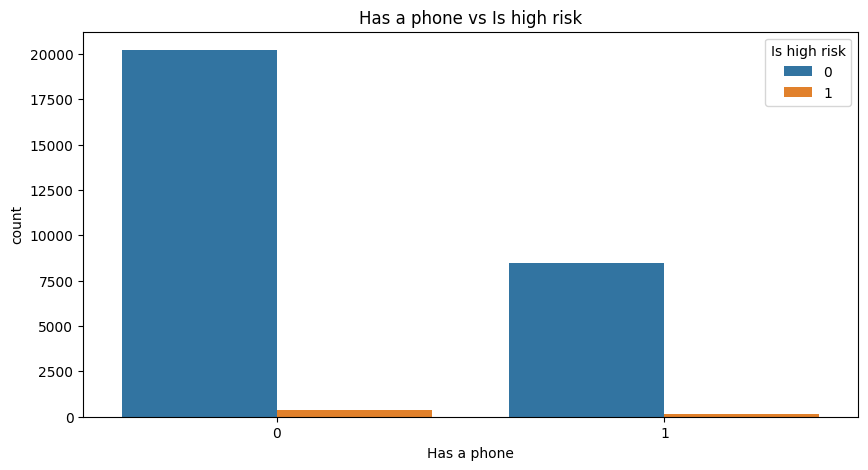

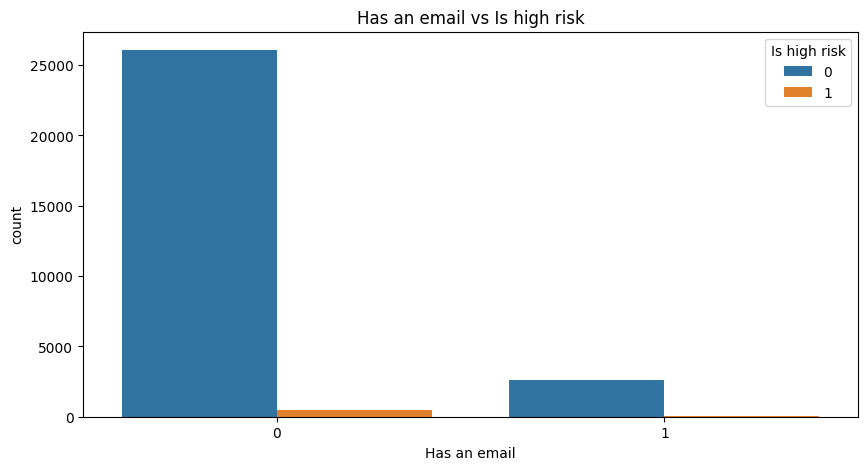

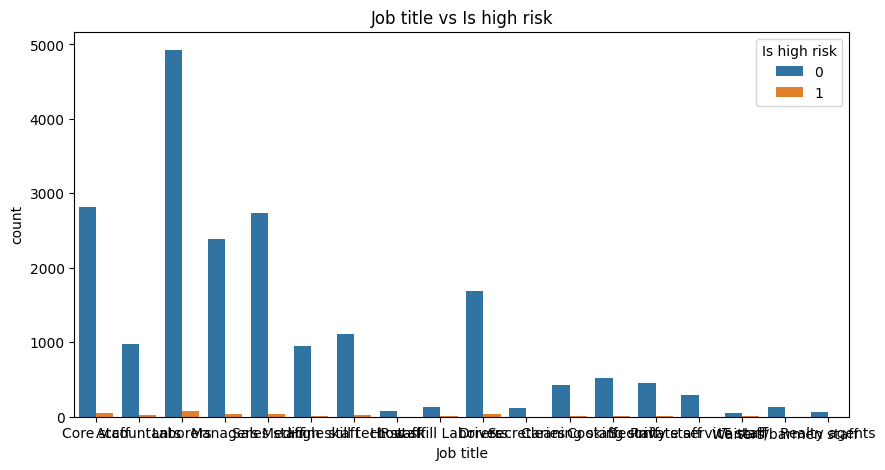

In [42]:
# Function to plot boxplots for numerical features against the target variable
def plot_boxplots(data, columns, target):
    for column in columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=target, y=column, data=data)
        plt.title(f'{column} vs {target}')
        plt.show()

# Plot boxplots for numerical columns against the target variable
plot_boxplots(train_data, numerical_columns, 'Is high risk')

# Function to plot countplots for categorical features against the target variable
def plot_countplots(data, columns, target):
    for column in columns:
        plt.figure(figsize=(10, 5))
        sns.countplot(x=column, hue=target, data=data)
        plt.title(f'{column} vs {target}')
        plt.show()

# List of categorical columns for bivariate analysis
categorical_columns = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level',
                       'Marital status', 'Dwelling', 'Has a mobile phone', 'Has a work phone',
                       'Has a phone', 'Has an email', 'Job title']

# Plot countplots for categorical columns against the target variable
plot_countplots(train_data, categorical_columns, 'Is high risk')




---


**Feature Engineering**

---



*Creating New Features*<br>
Create new features that could potentially improve model performance.

In [45]:
# Create new feature: Income per Family Member
train_data['Income per Family Member'] = train_data['Income'] / (train_data['Family member count'] + 1)
test_data['Income per Family Member'] = test_data['Income'] / (test_data['Family member count'] + 1)

# Create new feature: Has a Phone (combined mobile, work, and any phone)
train_data['Has a Phone'] = train_data[['Has a mobile phone', 'Has a work phone', 'Has a phone']].max(axis=1)
test_data['Has a Phone'] = test_data[['Has a mobile phone', 'Has a work phone', 'Has a phone']].max(axis=1)

# Drop the original 'Has a mobile phone', 'Has a work phone', 'Has a phone' columns as they are now combined
train_data.drop(['Has a mobile phone', 'Has a work phone', 'Has a phone'], axis=1, inplace=True)
test_data.drop(['Has a mobile phone', 'Has a work phone', 'Has a phone'], axis=1, inplace=True)




---


**Data Preprocessing**

---



*Handling Missing Values*

In [44]:
# Fill missing values for numerical columns with median
numerical_cols_with_missing = ['Income', 'Employment length', 'Account age']
for col in numerical_cols_with_missing:
    train_data[col].fillna(train_data[col].median(), inplace=True)
    test_data[col].fillna(test_data[col].median(), inplace=True)

# Fill missing values for categorical columns with mode
categorical_cols_with_missing = ['Gender', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for col in categorical_cols_with_missing:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)
    test_data[col].fillna(test_data[col].mode()[0], inplace=True)


*Encoding Categorical Variables*<br>
Encode categorical variables using one-hot encoding.

In [47]:
# Encoding categorical variables
categorical_columns = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level',
                       'Marital status', 'Dwelling', 'Has an email', 'Job title', 'Has a Phone']
train_data = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)
test_data = pd.get_dummies(test_data, columns=categorical_columns, drop_first=True)

# Ensure both train and test data have the same columns after one-hot encoding
train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)


*Scaling/Normalizing Features*<br>
Scale or normalize numerical features to bring them to a similar range.

In [49]:
from sklearn.preprocessing import StandardScaler
# Scaling numerical features
numerical_columns = ['Children count', 'Income', 'Age', 'Employment length', 'Family member count',
                     'Account age', 'Income per Family Member']
scaler = StandardScaler()
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])


In [50]:
# Separate features and target variable
X_train = train_data.drop(['ID', 'Is high risk'], axis=1)
y_train = train_data['Is high risk']
X_test = test_data.drop(['ID', 'Is high risk'], axis=1)
y_test = test_data['Is high risk']




---


**Model Development and Evalution**


---



In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# List of models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1-score: {f1_score(y_test, y_pred)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")



Model: Logistic Regression
Accuracy: 0.9842292923752057
Precision: 1.0
Recall: 0.017094017094017096
F1-score: 0.033613445378151266
ROC AUC: 0.5085470085470085
Confusion Matrix:
[[7175    0]
 [ 115    2]]

Model: Decision Tree
Accuracy: 0.9695556774547449
Precision: 0.1476510067114094
Recall: 0.18803418803418803
F1-score: 0.16541353383458648
ROC AUC: 0.5851669198010662
Confusion Matrix:
[[7048  127]
 [  95   22]]

Model: Random Forest
Accuracy: 0.981897970378497
Precision: 0.3404255319148936
Recall: 0.13675213675213677
F1-score: 0.1951219512195122
ROC AUC: 0.5662157896304237
Confusion Matrix:
[[7144   31]
 [ 101   16]]

Model: Gradient Boosting
Accuracy: 0.9838178826110806
Precision: 0.46153846153846156
Recall: 0.05128205128205128
F1-score: 0.0923076923076923
ROC AUC: 0.5251532207629769
Confusion Matrix:
[[7168    7]
 [ 111    6]]


The Random Forest model was chosen because it provides a reasonable balance between precision and recall, with a higher precision of 0.34 and a recall of 0.14 compared to other models. This model demonstrates better handling of both true positives and false positives, making it the most suitable for predicting credit card approvals.

In [52]:
best_model = models['Random Forest']
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)

# Display the feature importance scores
feature_importances = best_model.feature_importances_
feature_names = list(X_train.columns)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importance Scores:")
print(importance_df)

# Analyze the feature importance scores and provide recommendations
important_features = importance_df.head(10)['Feature'].tolist()
print("\nTop 10 Important Features:")
print(important_features)

# Recommendations based on the top features
print("\nRecommendations:")
print("1. Focus on applicants' income and employment status when evaluating credit card applications.")
print("2. Consider the applicant's age and account age as significant factors in the decision-making process.")
print("3. Prioritize applicants with stable employment and higher income per family member.")
print("4. Pay attention to applicants' marital status and number of family members.")
print("5. Enhance data collection for job titles and dwelling types to improve model performance.")



Feature Importance Scores:
                                          Feature    Importance
5                                     Account age  2.550485e-01
2                                             Age  1.607726e-01
3                               Employment length  1.160301e-01
6                        Income per Family Member  8.989937e-02
1                                          Income  8.340598e-02
4                             Family member count  2.474418e-02
8                                     Has a car_Y  2.181243e-02
0                                  Children count  1.993915e-02
7                                        Gender_M  1.965319e-02
13                      Employment status_Working  1.611734e-02
9                                Has a property_Y  1.557448e-02
35                             Job title_Laborers  1.428295e-02
17  Education level_Secondary / secondary special  1.351974e-02
14               Education level_Higher education  1.227131e-02
18          